# Задание 4.

* Реализовать решение СЛАУ двумя итерационными методами:
  1. методом простой итерации + методом Зейделя.
  2. Сравнить количество итераций.

‎
* Находить решения с разной точностью (т.е. варьировать ε, до достижения которого проводятся итерации). Определить наличие между ε и количеством итераций зависимости.
* Протестировать работу методов на плохо обусловленных матрицах.
* Протестировать работу методов на симметричных с диагональным преобладанием разреженных матрицах большого порядка (больше 200).

**Отчёт:** https://docs.google.com/document/d/1cT8XRA4xJxzMf_hWBOQmhwEHYN4MIIAX79oo2QDDlgY/edit?usp=sharing

# Imports

In [1]:
from collections import namedtuple
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import nbimporter

from common import generate_diagonal_dominance_matrix_element, generate_hilberts_matrix_element, generate_sparse_symmetric_diagonally_dominant_element

# Solution

In [2]:
SolutionUsingIterativeMethod = namedtuple('SolutionUsingIterativeMethod', ['x', 'iterations_count'])


def solve_using_iterative_method(B: np.ndarray, c: np.ndarray, epsilon: float, strict: bool) -> SolutionUsingIterativeMethod:
    n = B.shape[0]

    if strict and np.max(np.abs(np.linalg.eigvals(B))) >= 1:
        raise ValueError('p(B) >= 1')

    B_norm = np.linalg.norm(B, ord=np.inf)
    t = B_norm / (1 - B_norm)

    x = np.zeros(n)
    iterations_count = 0
    while True:
        previous_x = x.copy()
        x = B.dot(previous_x) + c
        iterations_count += 1

        # Check for convergence
        if t * np.linalg.norm(x - previous_x, ord=np.inf) < epsilon:
            break

    return SolutionUsingIterativeMethod(x, iterations_count)

In [3]:
def solve_using_simple_iterations_method(A: np.ndarray, b: np.ndarray, epsilon: float, strict: bool) -> SolutionUsingIterativeMethod:
    n = A.shape[0]
    
    # Check diagonal dominance or symmetric positive definiteness
    diag_dom = np.all(2 * np.abs(np.diag(A)) > np.sum(np.abs(A), axis=1))
    if diag_dom:
        B = -np.where(np.eye(n), 0, A / np.diag(A)[:, None])
        c = b / np.diag(A)
    else:
        eigen_values = np.linalg.eigvals(A)
        if strict and (np.any(eigen_values <= 0) or not np.allclose(A, A.T.conj())):
            raise ValueError('A without diagonal dominance and A != A*.')

        alpha = 2 / (np.min(eigen_values) + np.max(eigen_values))
        B, c = np.eye(n) - alpha * A, alpha * b

    return solve_using_iterative_method(B, c, epsilon, strict)

In [4]:
def solve_using_zeidels_method(A: np.ndarray, b: np.ndarray, epsilon: float, strict: bool) -> SolutionUsingIterativeMethod:
    n = A.shape[0]

    if strict and not np.all(2 * np.abs(np.diag(A)) > np.sum(np.abs(A), axis=1)):
        raise ValueError('A without diagonal dominance.')

    L = np.tril(A)
    R = A - L
    L_inverse = np.linalg.inv(L)
    B, c = -L_inverse.dot(R), L_inverse.dot(b)

    return solve_using_iterative_method(B, c, epsilon, strict)

# Tests

In [5]:
def test_solve_using_simple_iterations_method():
    num_matrices = 10
    matrix_size = 5
    epsilon = 0.001

    for _ in range(num_matrices):
        A = np.random.rand(matrix_size, matrix_size)
        A += np.diag(np.random.rand(matrix_size) * 1000)
        b = np.random.rand(matrix_size)

        solution = solve_using_simple_iterations_method(A, b, epsilon, False).x
        expected_solution = np.linalg.solve(A, b)
        assert np.allclose(solution, expected_solution, atol=epsilon), "Solution should match numpy.linalg.solve"

def test_solve_using_zeidels_method():
    num_matrices = 10
    matrix_size = 5
    epsilon = 0.001

    for _ in range(num_matrices):
        A = np.random.rand(matrix_size, matrix_size)
        A += np.diag(np.random.rand(matrix_size) * 1000)
        b = np.random.rand(matrix_size)

        solution = solve_using_zeidels_method(A, b, epsilon, False).x
        expected_solution = np.linalg.solve(A, b)
        assert np.allclose(solution, expected_solution, atol=epsilon), "Solution should match numpy.linalg.solve"

test_solve_using_simple_iterations_method()
test_solve_using_zeidels_method()

# Experiments

In [6]:
def check_solution_using_simple_iterations_method_hilberts_matrix():
    matrix_size = 10
    epsilon = 1e-3

    A = np.array([[generate_hilberts_matrix_element(row, column) for column in range(matrix_size)] for row in range(matrix_size)])
    b = np.random.rand(matrix_size)

    solution = solve_using_simple_iterations_method(A, b, epsilon, False).x
    expected_solution = np.linalg.solve(A, b)

    error = np.linalg.norm(solution - expected_solution)
    print(f"Error between iterative solution and NumPy's solution: {error}")


check_solution_using_simple_iterations_method_hilberts_matrix()

Error between iterative solution and NumPy's solution: 905946371780.3597


In [7]:
def run_experiment(matrix_size, epsilon, element_generator):
    A = np.array([[element_generator(row, column) for column in range(matrix_size)] for row in range(matrix_size)])
    b = np.random.rand(matrix_size)

    try:
        solution = solve_using_simple_iterations_method(A, b, epsilon, False)
        solution_simple = solution.x
        iterations_simple = solution.iterations_count
    except ValueError as e:
        solution_simple, iterations_simple = None, float('inf')
        print(f"Simple Iterations Method failed: epsilon: {epsilon}, error: {e}")

    try:
        solution = solve_using_zeidels_method(A, b, epsilon, False)
        solution_zeidel = solution.x
        iterations_zeidel = solution.iterations_count
    except ValueError as e:
        solution_zeidel, iterations_zeidel = None, float('inf')
        print(f"Zeidel's Method failed: epsilon: {epsilon}, error: {e}")

    return iterations_simple, iterations_zeidel

# Plotting the results
def plot_results(results):
    epsilon_values, iterations_simple, iterations_zeidel = zip(*results)
    
    plt.plot(epsilon_values, iterations_simple, label='Simple Iterations', marker='o')
    plt.plot(epsilon_values, iterations_zeidel, label="Zeidel's", marker='x')
    plt.xlabel('Epsilon')
    plt.ylabel('Number of Iterations')
    plt.xscale('log')
    plt.title('Iteration Counts for Various Epsilon Values')
    plt.legend()
    plt.show()

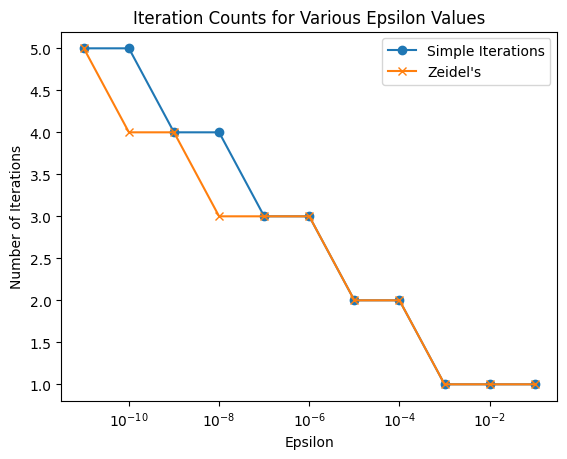

In [8]:
matrix_size = 100
epsilons = [10**-i for i in range(1, 12)]
results = []

for epsilon in epsilons:
    iterations_simple, iterations_zeidel = run_experiment(matrix_size, epsilon, generate_diagonal_dominance_matrix_element)
    results.append((epsilon, iterations_simple, iterations_zeidel))

plot_results(results)

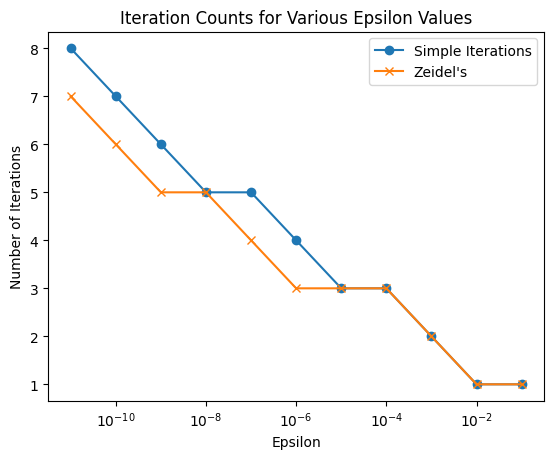

In [9]:
matrix_size = 250
epsilons = [10**-i for i in range(1, 12)]
results = []

for epsilon in epsilons:
    iterations_simple, iterations_zeidel = run_experiment(matrix_size, epsilon, generate_sparse_symmetric_diagonally_dominant_element)
    results.append((epsilon, iterations_simple, iterations_zeidel))

plot_results(results)